# Download and Unzip Function

To see the download and unzipping progress

In [1]:
!pip install lemma-dev-utils
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for lemma-dev-utils: filename=lemma_dev_utils-0.0.3-py3-none-any.whl size=4916 sha256=786c8fa4ba0c65bc2f74805d06e807f55e988acd0b6461f8bfb3b5b85d0b214c
  Stored in directory: /root/.cache/pip/wheels/18/10/d6/61f6e972fad08c7ffc400e9429eaaf3b511773d7a71cd5b6e7
Successfully built lemma-dev-utils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 50.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d1672c25e0da30928cd4dee8eada812bddc37e39b279a730b42b6b9c5d60e300
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


# Downloading the Dataset

In [2]:
with open('dataset_url.txt', 'r') as f:
    url = f.read()

In [3]:
from lemma_dev_utils import download_unzip
import os

path = 'dataset'

download_unzip(path, url)
os.chdir(path)

Unzipping train_labels.csv: 100%|##########| 30752769/30752769 [00:00<00:00, 71092381.31it/s]


# Setting up Spark

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shareddrives/Mie Robe')

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
        
sc = spark.sparkContext

# Loading the Training Set

In [ ]:
raw_data = sc.textFile("train_data.csv")
raw_labels = sc.textFile("train_labels.csv")

# Preprocessing



## Managing Numeric and NaN values

In [ ]:
import math

def isnumeric_val(val):
    non_negative = val.replace("-", "", 1)
    non_decimal = non_negative.replace(".", "", 1)
    non_scientific = non_decimal.replace("e-", "", 1).replace("e", "", 1)
    isitnumeric = non_scientific.isdigit()
    return isitnumeric

def clean_split_csv(row):
    # Split Row
    split_row = row.split(',')
    new_row = list()

    for val in split_row:
        # Fill NaN
        val = val if val != '' else '0.0'
        # Rounding numbers
        val_toadd = math.floor(float(val)*1000)/1000 if isnumeric_val(val) else val
        new_row.append(val_toadd)

    return tuple(new_row)

## Getting features, labels and the header

In [ ]:
# cleaning the training data
clean_data = raw_data.map(lambda row: clean_split_csv(row))
header_features = clean_data.take(1)[0]
features = clean_data.filter(lambda x: x != header_features)

# cleaning the training labels
clean_labels = raw_labels.map(lambda row: clean_split_csv(row))
header_labels = clean_labels.take(1)[0]
labels = clean_labels.filter(lambda x: x != header_labels)

## Sampling the dataset

In [ ]:
# sampled_data = features.sample(withReplacement = False, fraction = 0.1, seed = 42)

In [ ]:
sampled_data = features

## Get number of partitions I have

In [ ]:
sampled_data.getNumPartitions()

2

# From RDD to DF

In [ ]:
# %%time
# # around 26 minutes
# df = sampled_data.toDF(header_features)
# df_schema = df.schema
# df.write.csv("sample_train_data_(spark).csv")
# del df

In [ ]:
# df = spark.read.format("csv") \
#     .option("header", True) \
#     .schema(df_schema) \
#     .load("sample_train_data_(spark).csv")

In [ ]:
df = sampled_data.toDF(header_features)

In [ ]:
df.rdd.getNumPartitions()

2

## Checking column names

In [ ]:
df_columns = df.columns
len(header_features) == len(df_columns)

True

In [ ]:
header_features == tuple(df_columns)

True

In [ ]:
header_features[:5], df_columns[:5]

(('customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'),
 ['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'])

## Rename with original column names

## Looking at the dataset shape and schema

In [ ]:
df.show()

+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
schema = {col.name : str(col.dataType) for col in df.schema}
print(*[f"{x}\n" for x in schema.items() if x[1] != 'DoubleType()'])

('customer_ID', 'StringType()')
 ('S_2', 'StringType()')
 ('D_63', 'StringType()')
 ('D_64', 'StringType()')



In [ ]:
n_rows = df.count()
n_columns = len(df_columns)
print(f"n° o Rows: {n_rows}")
print(f"n° o Columns: {n_columns}")

n° o Rows: 10001
n° o Columns: 190


In [ ]:
df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- S_2: string (nullable = true)
 |-- P_2: double (nullable = true)
 |-- D_39: double (nullable = true)
 |-- B_1: double (nullable = true)
 |-- B_2: double (nullable = true)
 |-- R_1: double (nullable = true)
 |-- S_3: double (nullable = true)
 |-- D_41: double (nullable = true)
 |-- B_3: double (nullable = true)
 |-- D_42: double (nullable = true)
 |-- D_43: double (nullable = true)
 |-- D_44: double (nullable = true)
 |-- B_4: double (nullable = true)
 |-- D_45: double (nullable = true)
 |-- B_5: double (nullable = true)
 |-- R_2: double (nullable = true)
 |-- D_46: double (nullable = true)
 |-- D_47: double (nullable = true)
 |-- D_48: double (nullable = true)
 |-- D_49: double (nullable = true)
 |-- B_6: double (nullable = true)
 |-- B_7: double (nullable = true)
 |-- B_8: double (nullable = true)
 |-- D_50: double (nullable = true)
 |-- D_51: double (nullable = true)
 |-- B_9: double (nullable = true)
 |-- R_3: double (nullable = t

In [ ]:
# input from American Express challenge
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
categorical_df = df.select(categorical_variables)

In [ ]:
categorical_df.show()

+----+----+-----+-----+-----+-----+-----+----+----+----+----+
|B_30|B_38|D_114|D_116|D_117|D_120|D_126|D_63|D_64|D_66|D_68|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0|  1.0|  CL|   O| 0.0| 6.0|
| 0.0| 1.0|  1.0|  0.0|  2.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  3.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 1.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 1.0|  0.0|  0.0| -1.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 1.0| 4.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 3.0|  0.0|  0.0|  2.0|  0.0|  0.0|  CL|   U| 0.0| 2.0|
| 0.0| 2.0|  1.0|  0.0|  6.0|  0.0|  0.0|  CR|   O| 0.0| 5.0|
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0| -1.0|  CR|   O| 0.0| 5.0|
| 0.0| 1.0|  0.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 5.0|
| 0.0| 1.0|  1.0|  0.0|  4.0|  0.0|  0.0|  CO|   O| 0.0| 6.0|
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0|  1.0|  CO|   R| 0.0| 5.0|
| 0.0| 7.0|  0.0|  0.0|  4.0|  0.0|  0.0|  CO|   U| 0.0| 4.0|
| 0.0| 2

In [ ]:
categorical_df.describe().show()

+-------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+------------------+
|summary|               B_30|              B_38|              D_114|               D_116|             D_117|              D_120|             D_126| D_63|                D_64|               D_66|              D_68|
+-------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+------------------+
|  count|              10001|             10001|              10001|               10001|             10001|              10001|             10001|10001|               10001|              10001|             10001|
|   mean|0.15828417158284172| 2.719128087191281|  0.593040695930407|0.001599840015998...|2.2386761323867614|0.11078892110788921|0.72262773722627

In [ ]:
categorical_df.describe().filter("summary = 'max'").collect()

[Row(summary='max', B_30='2.0', B_38='7.0', D_114='1.0', D_116='1.0', D_117='6.0', D_120='1.0', D_126='1.0', D_63='XZ', D_64='U', D_66='1.0', D_68='6.0')]

In [ ]:
categorical_df.describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='-1.0', D_120='0.0', D_126='-1.0', D_63='CL', D_64='-1.0', D_66='0.0', D_68='0.0')]

D_117 and D_126 may be a problem as they were known values but we changed the nan values to 0, they have negative values I'll make them 0.5 to adjust to a category semantically closer to the original one

# Fixing the negative values appearing in the categories

In [ ]:
from pyspark.sql.functions import col, when

for i in ['D_117', 'D_126', 'D_64']:
    df = df.withColumn(i, when((col(i) == -1.0), 0.5).otherwise(col(i)))

In [ ]:
df.select(categorical_variables).describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='0.0', D_120='0.0', D_126='0.0', D_63='CL', D_64='0.0', D_66='0.0', D_68='0.0')]

# Casting string-type categories to numeric
As per the request of Spark

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

new_categorical_variables = [f'{col}_numeric' for col in categorical_variables]
indexer = StringIndexer(inputCols=categorical_variables, outputCols=new_categorical_variables).fit(df)
df = indexer.transform(df)

In [ ]:
categorical_df = df.select(categorical_variables+new_categorical_variables)

In [ ]:
categorical_df.groupby(['B_38_numeric', 'B_38']).count().show()

+------------+----+-----+
|B_38_numeric|B_38|count|
+------------+----+-----+
|         3.0| 5.0|  827|
|         6.0| 6.0|  277|
|         4.0| 4.0|  512|
|         7.0| 0.0|    4|
|         2.0| 1.0| 2032|
|         1.0| 3.0| 2344|
|         0.0| 2.0| 3550|
|         5.0| 7.0|  455|
+------------+----+-----+



In [ ]:
categorical_df.groupby(['D_63_numeric', 'D_63']).count().show()

+------------+----+-----+
|D_63_numeric|D_63|count|
+------------+----+-----+
|         3.0|  XZ|   46|
|         5.0|  XL|    9|
|         4.0|  XM|   16|
|         0.0|  CO| 7451|
|         2.0|  CL|  753|
|         1.0|  CR| 1726|
+------------+----+-----+



In [ ]:
# somewhat a heavy operation (it could be avoided) but I prefer to keep the original category labels
reverse_dictionary = {col : dict(categorical_df.groupby([f'{col}_numeric', col]).count()\
                                 .drop('count').collect()) for col in categorical_variables}

reverse_dictionary['D_63']

{3.0: 'XZ', 5.0: 'XL', 4.0: 'XM', 0.0: 'CO', 2.0: 'CL', 1.0: 'CR'}

In [ ]:
reverse_dictionary.keys()

dict_keys(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'])

In [ ]:
# dropping old columns from dataframe
df = df.drop(*categorical_variables)

# One hot encoding Categorical variables

In [ ]:
from pyspark.ml.feature import OneHotEncoder

output_col_names = [f'{col}_enc' for col in categorical_variables]
encoder = OneHotEncoder(inputCols = new_categorical_variables, 
                        outputCols = output_col_names)

model = encoder.fit(df)
df = model.transform(df)

# dropping the numeric columns from df
df = df.drop(*new_categorical_variables)

df.select(output_col_names).show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     B_30_enc|     B_38_enc|    D_114_enc|    D_116_enc|    D_117_enc|    D_120_enc|    D_126_enc|     D_63_enc|     D_64_enc|     D_66_enc|     D_68_enc|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|(2,[0],[1.0])|(7,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[2],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[3],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[0],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],

In [ ]:
# renaming back columns to original names
for encoded_name, original_name in zip(output_col_names, categorical_variables):
    df = df.withColumnRenamed(encoded_name, original_name)

# Getting the Labels to Join them

In [ ]:
label_df = labels.toDF()
label_cols = label_df.columns
for label_wrong_col, label_correct_col in zip(label_cols, header_labels):
    label_df = label_df.withColumnRenamed(label_wrong_col, label_correct_col)
label_df.show()

+--------------------+------+
|         customer_ID|target|
+--------------------+------+
|0000099d6bd597052...|   0.0|
|00000fd6641609c6e...|   0.0|
|00001b22f846c82c5...|   0.0|
|000041bdba6ecadd8...|   0.0|
|00007889e4fcd2614...|   0.0|
|000084e5023181993...|   0.0|
|000098081fde4fd64...|   0.0|
|0000d17a1447b25a0...|   0.0|
|0000f99513770170a...|   1.0|
|00013181a0c5fc8f1...|   1.0|
|0001337ded4e1c253...|   1.0|
|00013c6e1cec7c21b...|   1.0|
|0001812036f155833...|   1.0|
|00018dd4932409baf...|   0.0|
|000198b3dc70edd65...|   0.0|
|000201146e53cacdd...|   0.0|
|0002d381bdd8048d7...|   0.0|
|0002e335892f7998f...|   1.0|
|00031e8be98bc3411...|   0.0|
|000333075fb8ec6d5...|   1.0|
+--------------------+------+
only showing top 20 rows



In [ ]:
df = df.join(label_df, ['customer_ID'])

In [ ]:
from pyspark.ml.feature import VectorAssembler

columns_final = ['customer_ID', 'S_2', 'target']
feature_to_assemble = [col for col in header_features if col not in columns_final]

vecAssembler = VectorAssembler(inputCols=feature_to_assemble, 
                               outputCol="features")

assembled_df = vecAssembler.transform(df).select(columns_final+['features'])

In [ ]:
assembled_df.show()

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.96,0.006,0.001...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.829,1.037,0.04...|
|0033da35db3a15c28...|2017-08-29|   1.0|[0.273,0.384,0.02...|
|003f7b33280fff053...|2017-11-22|   1.0|[0.528,0.008,0.00...|
|004f500fb6369857e...|2017-09-08|   1.0|[0.323,0.006,0.00...|
|005382536094338c2...|2017-09-16|   0.0|[0.281,0.031,0.04...|
|005c74962a7c912f9...|2017-11-10|   1.0|[0.473,0.03,0.675...|
|005f7ccc9c4131b73...|2018-02-28|   0.0|[0.891,0.003,0.00...|
|006078e5943de3f1f...|2017-09-26|   0.0|[0.966,0.002,0.00...|
|00675c719a9666275...|2017-03-06|   0.0|[0.94,0.006,0.072...|
|0081622

# Feature Selection

In [ ]:
from pyspark.ml.feature import UnivariateFeatureSelector

# ChiSqSelector - Deprecated since version 3.1.0: Thus UnivariateFeatureSelector

selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="target", selectionMode="numTopFeatures")

selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)

columns_final.append('selectedFeatures')

fitting = selector.fit(assembled_df)
selected_feat = fitting.selectedFeatures

result = fitting.transform(assembled_df).select(columns_final)

print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector.getSelectionThreshold())

UnivariateFeatureSelector output with top 20 features selected using f_classif


In [ ]:
result.take(1)

[Row(customer_ID='0014d951622647e823722b75013b52df120f9ca0f8acc57321616e6a4a1f80f7', S_2='2018-02-01', target=0.0, selectedFeatures=DenseVector([0.902, 0.091, 0.031, 1.001, 0.009, 0.213, 0.0, 0.004, 0.0, 0.0, 0.004, 0.038, 1.001, 0.006, 0.436, 0.734, 0.029, 0.0, 0.187, 0.03]))]

In [ ]:
#selected explicit features
new_header = [col for col in df.columns if col not in columns_final]
sel_feat_expl = [new_header[n] for n in selected_feat]

In [ ]:
import re
from collections import Counter

# getting the distribution of the original type of variables
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

orig_cdist = Counter(re.findall('\w*_', ' '.join(new_header)))

print(orig_cdist)

Counter({'D_': 96, 'B_': 40, 'R_': 28, 'S_': 21, 'P_': 3})


In [ ]:
selected_cdist = Counter(re.findall('\w*_', ' '.join(sel_feat_expl)))

print(selected_cdist)

Counter({'D_': 10, 'B_': 6, 'R_': 2, 'P_': 1, 'S_': 1})


# Train-test split
Not stratified (yet to implement)

In [ ]:
train, validation = result.randomSplit(weights=[0.8,0.2], seed=42)

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="target", featuresCol="selectedFeatures", seed=42, numTrees=30)
model = rf.fit(train)

In [ ]:
rf_feat_imp = model.featureImportances

In [ ]:
feat_by_imp = sorted(list(zip(rf_feat_imp.indices, rf_feat_imp.toArray())), key = lambda x: -x[1])
correct_feat_by_imp = [(sel_feat_expl[tup[0]], tup[1]) for tup in feat_by_imp]

In [ ]:
predictions = model.transform(validation)

In [ ]:
predictions.show()

+--------------------+----------+------+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|target|    selectedFeatures|       rawPrediction|         probability|prediction|
+--------------------+----------+------+--------------------+--------------------+--------------------+----------+
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|[17.5251991410550...|[0.58417330470183...|       0.0|
|003f7b33280fff053...|2017-11-22|   1.0|[0.528,0.008,0.00...|[22.1281182823531...|[0.73760394274510...|       0.0|
|005382536094338c2...|2017-09-16|   0.0|[0.281,0.031,0.04...|[24.5349586297951...|[0.81783195432650...|       0.0|
|0081622f92bc7b661...|2018-02-10|   0.0|[0.911,0.068,0.01...|[29.1650472085114...|[0.97216824028371...|       0.0|
|00be9aec004505277...|2017-03-22|   0.0|[0.608,0.004,0.03...|[23.9430346069989...|[0.79810115356663...|       0.0|
|00f1a29d193758630...|2017-10-14|   0.0|[0.998,0.008,0.03...|[29.2693243596109..

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

class_report = dict()

for metric in ['f1', 'accuracy', 'recallByLabel', 'precisionByLabel']:
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="target",
                                                  predictionCol="prediction",
                                                  metricName=metric,
                                                  metricLabel = 1)

    class_report[metric] = evaluator.evaluate(predictions)
    print(f"{metric}: {class_report[metric]}")

f1: 0.8447903154874403
accuracy: 0.8480620155038759
recallByLabel: 0.6354166666666666
precisionByLabel: 0.7193396226415094


In [ ]:
from sklearn.metrics import classification_report as cr

liste = predictions.select(['target', 'prediction']).collect()

y_test = [row.target for row in liste]
y_pred = [row.prediction for row in liste]

print(cr(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1455
         1.0       0.72      0.64      0.67       480

    accuracy                           0.85      1935
   macro avg       0.80      0.78      0.79      1935
weighted avg       0.84      0.85      0.84      1935



# PCA

In [ ]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(assembled_df)
pca_df = model.transform(assembled_df)

In [ ]:
pca_df.show()

+--------------------+----------+------+--------------------+--------------------+
|         customer_ID|       S_2|target|            features|        pca_features|
+--------------------+----------+------+--------------------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|[0.00326475286152...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.96,0.006,0.001...|[0.00385749576992...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|[0.00937803901764...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|[0.01962854750359...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.829,1.037,0.04...|[0.00516078085079...|
|0033da35db3a15c28...|2017-08-29|   1.0|[0.273,0.384,0.02...|[0.01242020267577...|
|003f7b33280fff053...|2017-11-22|   1.0|[0.528,0.008,0.00...|[0.00324598474620...|
|004f500fb6369857e...|2017-09-08|   1.0|[0.323,0.006,0.00...|[0.00750254621604...|
|005382536094338c2...|2017-09-16|   0.0|[0.281,0.031,0.04...|[0.00485650722388...|
|005

In [ ]:
sampled_pca_out = pca_df.sample(withReplacement = False, fraction = 0.99, seed = 42)
data_pca_collected = sampled_pca_out.select('pca_features').collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])

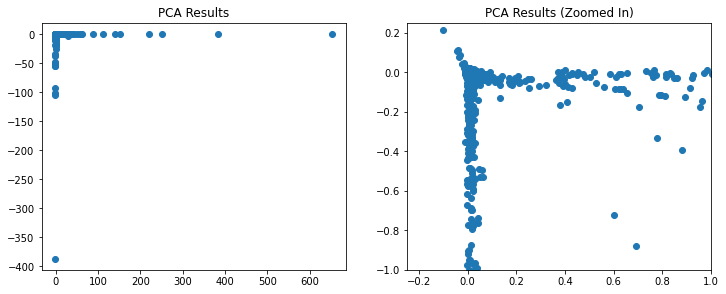

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1])

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1])
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.show()


In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(assembled_df.select('features'))

# Make predictions
predictions = model.transform(assembled_df.select('features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.3316527680742651
Cluster Centers: 
[7.47807549e-01 1.08574966e-01 3.05660152e-02 8.65852305e-01
 2.23702820e-02 1.39453677e-01 2.33158287e-02 1.51514247e-02
 1.90232732e-02 8.22182605e-02 3.78102342e-02 8.28458899e-02
 2.75644637e-01 1.07932717e-01 1.20005967e-02 3.30117559e-01
 4.35841265e-01 1.90411010e-01 1.00026854e-02 2.01221393e-01
 8.53860958e-02 3.81827242e-01 8.78957183e-02 1.79828883e-01
 5.79107862e-02 9.92309414e-02 2.02960018e-01 5.89331195e-01
 3.03366552e-01 4.62673430e-03 5.15276742e-02 2.28206773e-02
 3.06902581e-01 9.92911532e-01 7.76771595e-03 1.35939132e-01
 1.12264061e-01 3.48744592e-01 1.63343876e-01 1.08742802e-01
 1.11034462e-01 7.36043563e-03 1.08649709e-01 3.39471878e-02
 5.78167984e-02 3.30189467e-01 3.85447113e-01 2.37389080e-01
 4.00736983e-02 3.81083992e-01 2.12907355e-01 7.26838729e-01
 2.04535283e-01 6.05698941e-02 4.92316873e-03 1.93943011e-03
 5.64970909e-01 2.41533642e-01 1.41876772e-01 4.43085186e-02
 1.

In [ ]:
cluster_pca = pca_df.join(predictions, 'features')

In [ ]:
sampled_pca_out = cluster_pca.sample(withReplacement = False, fraction = 0.99, seed = 42)
data_pca_collected = sampled_pca_out.select(['pca_features', 'prediction', 'target']).collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])
colors = np.array([row.prediction for row in data_pca_collected])
colors_true = np.array([row.target for row in data_pca_collected])

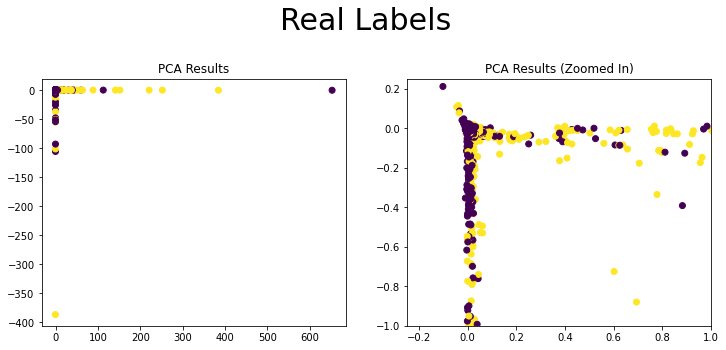

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Real Labels', fontsize = 30)
plt.show()


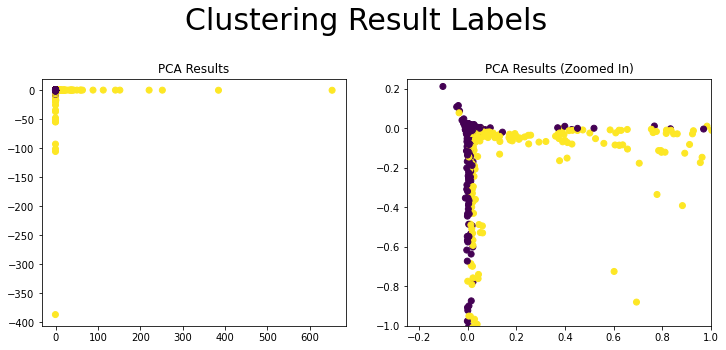

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Clustering Result Labels', fontsize = 30)
plt.show()
